In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
from preprocessing.load_dataset import raw_to_dict

In [28]:
trainset, valset = raw_to_dict(data_mode = "small")


100%|██████████| 50/50 [00:00<00:00, 139996.80it/s]

100%|██████████| 50/50 [00:00<00:00, 12800.78it/s]


>> Loading msimut at /Users/timothytiet/Documents/MyProject/code/python/ucla-cs168/data/msimut_small
>> Total running 1000

>> Loading msimut at /Users/timothytiet/Documents/MyProject/code/python/ucla-cs168/data/mss_small
>> Total running 1000

>> Splitting the dataset

>> From dictionary to data instance

>> Done!


In [29]:
batch_size = 4
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = 0)
valloader = torch.utils.data.DataLoader(valset, batch_size = batch_size, num_workers = 0)
len(trainloader), len(valloader)

(19, 12)

torch.Size([4, 3, 224, 224]) torch.Size([4])


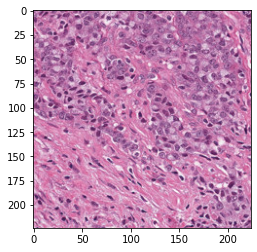

In [30]:
images, labels = next(iter(trainloader))

print(images.shape, labels.shape)
def imshow(img):
    inp = img.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    # plt.show()

imshow(images[0])

# Start to train

In [111]:
import pytorch_lightning as pl

In [122]:
from models.baseline import BaseLineModel

In [123]:
model_trainer = BaseLineModel(trainloader, valloader)

In [124]:
trainer = pl.Trainer(nb_sanity_val_steps=0, max_epochs = 8)

INFO:lightning:GPU available: False, used: False


In [125]:
trainer.fit(model_trainer)

INFO:lightning:
   | Name                           | Type              | Params
-----------------------------------------------------------------
0  | resnet18                       | ResNet            | 11 M  
1  | resnet18.conv1                 | Conv2d            | 9 K   
2  | resnet18.bn1                   | BatchNorm2d       | 128   
3  | resnet18.relu                  | ReLU              | 0     
4  | resnet18.maxpool               | MaxPool2d         | 0     
5  | resnet18.layer1                | Sequential        | 147 K 
6  | resnet18.layer1.0              | BasicBlock        | 73 K  
7  | resnet18.layer1.0.conv1        | Conv2d            | 36 K  
8  | resnet18.layer1.0.bn1          | BatchNorm2d       | 128   
9  | resnet18.layer1.0.relu         | ReLU              | 0     
10 | resnet18.layer1.0.conv2        | Conv2d            | 36 K  
11 | resnet18.layer1.0.bn2          | BatchNorm2d       | 128   
12 | resnet18.layer1.1              | BasicBlock        | 73 K  
13 | res

>> Reset scheduler


>> Reset scheduler



1

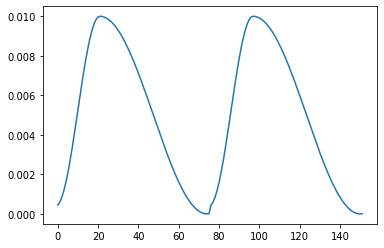

In [126]:
model_trainer.show_lr()